## 📦 Importing Required Libraries

We start by importing essential PyTorch modules, transformation tools, and visualization libraries. These will support model definition, data loading, and result visualization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
import numpy as np


## 🔗 Mounting Google Drive

We mount Google Drive to access our saved model weights and test datasets.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# **🧠 Evaluation: TL-S-CycleGAN (ResNet-50 Discriminator)**

Here, we evaluate the **Transfer Learning based Simple CycleGAN (TL-S-CycleGAN)** model that uses a **ResNet-50** backbone as its discriminator. By incorporating ResNet-50 — a deep, pretrained convolutional neural network — we aim to enhance the model's ability to distinguish between translated and real images through deeper feature extraction. This evaluation assesses how the ResNet-based discriminator affects translation quality and realism.


## 🧬 Defining the ResNet Generator

The generator is built using a deep ResNet-based architecture, which includes an initial convolution block, downsampling, several ResNet blocks with skip connections, and upsampling. This network is designed to perform image-to-image translation.


## 🔁 Defining the ResNet Block

Each ResNet block includes two convolution layers with normalization and optional dropout, combined with a skip connection. These are the building blocks of the generator.


In [ ]:
#######Generator##########
#########################

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=9, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf #no of generator filters
        #n_blocks = resnet blocks

        #Initial convlutional block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        # Downsample
        #reducing spatial dimensions
        n_downsampling = 2 #no. of downsampling layers
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        # Resnet blocks
        #using shortcut connections bypassing few layers
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type='reflect', norm_layer=norm_layer, use_dropout=use_dropout, use_bias=True)]

        # Upsample
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)
#resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        # Create the convolutional block
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)
    #function to build convolution block
    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = [] #to hold layers
        p = 0

        #determining padding type for first layer
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        else:
            p = 1  # 'zero' padding
        #first convolution layer
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        #opyional dropout layer
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        #determining padding type for 2nd layer
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        else:
            p = 1  # 'zero' padding
        #second convolutional block
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

## 🛡️ Defining the Discriminator – ResNet-50 Based

In this model, we use a pretrained **ResNet-50** backbone (excluding its final FC layer) and attach a custom real/fake classifier. This setup allows the discriminator to use strong pretrained features from ResNet to improve adversarial training.


In [ ]:
##########Discriminator#################
#######################################

import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights #pre trained resnet 50 with weights

class ResNet50DualOutputDiscriminator(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50DualOutputDiscriminator, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT) #resnet50 model with pretrained resnet50 weights
        self.resnet.fc = nn.Identity()  # Removing the fully connected layer with identity layer
        #real/fake classifier
        self.rf_classifier = nn.Sequential(
            nn.Linear(2048, 512), #reducing features from 2048 to 512
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1), #reducing features from 512 to 1
            nn.Sigmoid() #output probablity
        )

    def forward(self, x):
        features = self.resnet(x) #passing the input through resnet50
        real_fake_output = self.rf_classifier(features) #passing extracted through real/fake classifier
        return real_fake_output


## ⚙️ Setting Model Hyperparameters

Here, we define important parameters such as the number of channels, number of ResNet blocks, learning rate, and the momentum term `beta1` used in Adam optimizer.


In [ ]:
input_nc = 3  # number of channels in the input images
output_nc = 3  # number of channels in the output images
n_residual_blocks = 9  # typical number for a CycleGAN

lr = 0.0002
beta1 = 0.5

## 💾 Loading Pretrained CycleGAN Models

We load the trained generators and discriminators from previously saved checkpoints on Google Drive. We also use a utility function to allow for partial parameter matching in case of architecture changes.


In [ ]:
# Paths to the saved models
G_A2B_path = '/content/drive/MyDrive/resnet_50_CycleGAN_Models/netG_A2B_epoch_24.pth'
G_B2A_path = '/content/drive/MyDrive/resnet_50_CycleGAN_Models/netG_B2A_epoch_24.pth'
D_A_path = '/content/drive/MyDrive/resnet_50_CycleGAN_Models/netD_A_epoch_24.pth'
D_B_path = '/content/drive/MyDrive/resnet_50_CycleGAN_Models/netD_B_epoch_24.pth'

# Load the models
G_A2B = ResnetGenerator(input_nc,output_nc).to(device)
G_B2A = ResnetGenerator(input_nc,output_nc).to(device)
D_A = ResNet50DualOutputDiscriminator(input_nc).to(device)
D_B = ResNet50DualOutputDiscriminator(input_nc).to(device)

def load_model_ignore_mismatch(model, state_dict):
    model_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

# Usage example:
# Load the trained models with map_location for CPU
G_A2B.load_state_dict(torch.load(G_A2B_path, map_location=torch.device('cpu')))
G_B2A.load_state_dict(torch.load(G_B2A_path, map_location=torch.device('cpu')))

state_dict_D_A = torch.load(D_A_path, map_location=torch.device('cpu'))
state_dict_D_B = torch.load(D_B_path, map_location=torch.device('cpu'))

load_model_ignore_mismatch(D_A, state_dict_D_A)
load_model_ignore_mismatch(D_B, state_dict_D_B)

#load_model_ignore_mismatch(D_A_path, map_location=torch.device('cpu')))
#load_model_ignore_mismatch(D_B_path, map_location=torch.device('cpu')))

#D_A.load_state_dict(torch.load(D_A_path, map_location=torch.device('cpu')))
#D_B.load_state_dict(torch.load(D_B_path, map_location=torch.device('cpu')))





Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.6MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 🧹 Transformations for Test Data

We normalize the images to the range [-1, 1] using torchvision transforms to match the training input format.


In [ ]:
# Load Data
#Sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


## 📁 Loading the Test Datasets

Test data consists of benign and malignant images stored in separate folders. These are loaded into dataloaders for batch-wise evaluation.


In [ ]:
# Load test datasets
test_dataset_A = datasets.ImageFolder(root='/content/drive/MyDrive/my_data/test/benign', transform=transform)  # Load benign test dataset
test_dataset_B = datasets.ImageFolder(root='/content/drive/MyDrive/my_data/test/malignant', transform=transform)  # Load malignant test dataset

# Data loaders
test_loader_A = DataLoader(test_dataset_A, batch_size=1, shuffle=False)
test_loader_B = DataLoader(test_dataset_B, batch_size=1, shuffle=False)


### 🧠 Loading FCN for Semantic Segmentation

We optionally use a pretrained **FCN ResNet-50** model to generate segmentation maps for evaluating how well the translated images preserve medical structure via IoU and pixel-wise accuracy.


In [ ]:
import torch
import torchvision.models.segmentation as segmentation

# Load pre-trained FCN model
fcn_model = segmentation.fcn_resnet50(pretrained=True).eval().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:07<00:00, 19.1MB/s]


## 📐 Segmentation Evaluation Metrics (Optional)

If segmentation evaluation is enabled, we calculate:
- IoU (Intersection over Union)
- Per-pixel Accuracy
- Per-class Accuracy

These are used to measure anatomical consistency between real and generated images.


In [ ]:
import torch
import torchvision.models.segmentation as segmentation
from sklearn.metrics import jaccard_score
import numpy as np

# Load pre-trained FCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fcn_model = segmentation.fcn_resnet50(pretrained=True).eval().to(device)

def get_segmentation_map(image, model):
    if len(image.shape) == 4:
        # Image is already in the correct shape
        input_tensor = image
    elif len(image.shape) == 3:
        # Add batch dimension
        input_tensor = image.unsqueeze(0)
    else:
        raise ValueError(f"Unexpected input shape: {image.shape}")

    with torch.no_grad():
        output = model(input_tensor)['out']
        seg_map = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    return seg_map

def calculate_iou(seg_map_real, seg_map_fake):
    seg_map_real_flat = seg_map_real.flatten()
    seg_map_fake_flat = seg_map_fake.flatten()
    return jaccard_score(seg_map_real_flat, seg_map_fake_flat, average='macro')

# Example usage for a batch of images
iou_scores = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 📂 Setup Directories for Generated and Real Images

We create dedicated directories in Google Drive to store generated and original test images for visualization and result sharing.


In [ ]:
import os
from torchvision.utils import save_image
# Directories for saving generated test images
os.makedirs('/content/drive/MyDrive/test_generated_by_resnet50_cyclegan/benign_to_malignant', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_generated_by_resnet50_cyclegan/malignant_to_benign', exist_ok=True)
# Directories for saving real test images
os.makedirs('/content/drive/MyDrive/test_real_by_resnet50_cyclegan/real_benign', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_real_by_resnet50_cyclegan/real_malignant', exist_ok=True)

## 📊 Image Quality Metrics: SSIM, PSNR, MSE

In this loop:
- We generate fake images from real benign and malignant inputs.
- Compute **SSIM** (Structural Similarity Index), **PSNR** (Peak Signal-to-Noise Ratio), and **MSE** (Mean Squared Error) between the real and generated images.
- Print image shapes for sanity checks.
- Transpose tensors to NumPy arrays for metric calculation.

This helps assess how close the generated images are to real ones visually and statistically.


In [ ]:
import os
import torch
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Function to compute MSE
def mse(img1, img2):
    return F.mse_loss(img1, img2).item()

# Lists to store metrics
r_50_ssim_values = []
r_50_psnr_values = []
r_50_mse_values = []

with torch.no_grad():
    for i, (data_A, data_B) in enumerate(zip(test_loader_A, test_loader_B)):
        print(f'Processing image {i+1}')
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        #save_image(fake_B, f'/content/drive/MyDrive/test_generated_by_resnet50_cyclegan/benign_to_malignant/{i}.png')
        #save_image(fake_A, f'/content/drive/MyDrive/test_generated_by_resnet50_cyclegan/malignant_to_benign/{i}.png')
        #save_image(real_A, f'/content/drive/MyDrive/test_real_by_resnet50_cyclegan/real_benign/{i}.png')
        #save_image(real_B, f'/content/drive/MyDrive/test_real_by_resnet50_cyclegan/real_malignant/{i}.png')

        # Check shapes before transposing
        print(f'Shape of real_A: {real_A.shape}')
        print(f'Shape of real_B: {real_B.shape}')
        print(f'Shape of fake_A: {fake_A.shape}')
        print(f'Shape of fake_B: {fake_B.shape}')

        # Remove batch dimension and convert images to numpy arrays
        real_A_np = real_A[0].cpu().numpy().transpose(1, 2, 0)
        real_B_np = real_B[0].cpu().numpy().transpose(1, 2, 0)
        fake_A_np = fake_A[0].cpu().numpy().transpose(1, 2, 0)
        fake_B_np = fake_B[0].cpu().numpy().transpose(1, 2, 0)

        # Compute metrics for benign to malignant
        ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
        psnr_value = psnr(real_B_np, fake_B_np)
        mse_value = mse(real_B, fake_B)

        r_50_ssim_values.append(ssim_value)
        r_50_psnr_values.append(psnr_value)
        r_50_mse_values.append(mse_value)

        # Compute metrics for malignant to benign
        ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)
        psnr_value = psnr(real_A_np, fake_A_np)
        mse_value = mse(real_A, fake_A)

        r_50_ssim_values.append(ssim_value)
        r_50_psnr_values.append(psnr_value)
        r_50_mse_values.append(mse_value)

        # Get segmentation maps
        #seg_map_real_B = get_segmentation_map(real_B, fcn_model)
        #seg_map_fake_B = get_segmentation_map(fake_B, fcn_model)
        #seg_map_real_A = get_segmentation_map(real_A, fcn_model)
        #seg_map_fake_A = get_segmentation_map(fake_A, fcn_model)

        # Calculate IoU
        #iou_B = calculate_iou(seg_map_real_B, seg_map_fake_B)
        #iou_A = calculate_iou(seg_map_real_A, seg_map_fake_A)

        #iou_scores.append((iou_A + iou_B) / 2)  # Average IoU for both directions

         # Calculate metrics for benign to malignant
        #ppa_B = calculate_per_pixel_accuracy(seg_map_real_B, seg_map_fake_B)
        #pca_B = calculate_per_class_accuracy(seg_map_real_B, seg_map_fake_B)

        # Calculate metrics for malignant to benign
       # ppa_A = calculate_per_pixel_accuracy(seg_map_real_A, seg_map_fake_A)
       # pca_A = calculate_per_class_accuracy(seg_map_real_A, seg_map_fake_A)

        # Average metrics for both directions
       # ppa_scores.append((ppa_A + ppa_B) / 2)
        #pca_scores.append((pca_A + pca_B) / 2)

Processing image 1
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-12-2cbc7cfc0025>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-12-2cbc7cfc0025>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 2
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 3
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 4
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 5
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 6
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1,

## 🖼️ Visual Comparison of Real vs Generated Images

We define a utility function to visualize side-by-side comparisons of real and generated images using `matplotlib`.

This is crucial for visually judging translation quality.


In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_single_real_and_fake_image(real_image, fake_image):
    """
    Plots a comparison of a single real and a single generated (fake) image.

    Parameters:
    - real_image: a single Tensor image (C, H, W).
    - fake_image: a single Tensor image (C, H, W).
    """
    plt.figure(figsize=(8, 4))

    # Display the real image
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Image")
    real_image = vutils.make_grid(real_image, normalize=True).permute(1, 2, 0).cpu().numpy()
    plt.imshow(real_image)

    # Display the fake image
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Generated Image")
    fake_image = vutils.make_grid(fake_image, normalize=True).permute(1, 2, 0).cpu().numpy()
    plt.imshow(fake_image)

    plt.show()

## 🔍 Displaying Example Results

We run a loop to show three example comparisons of real and generated images in both directions (benign → malignant and malignant → benign). These plots are useful for quick visual verification.


Image :  0


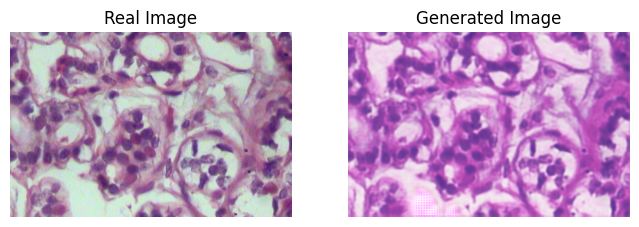

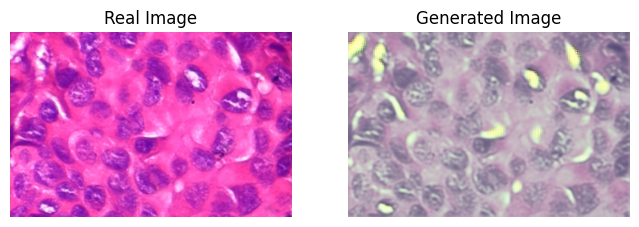

Image :  1


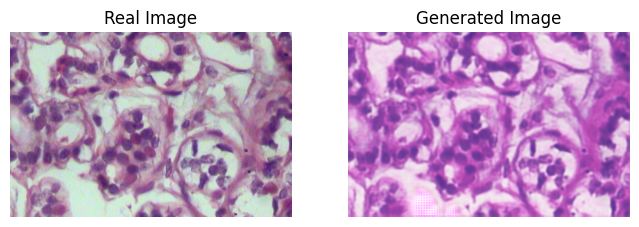

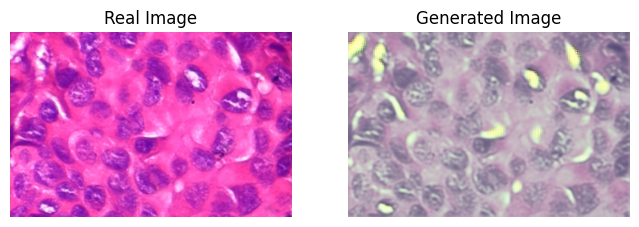

Image :  2


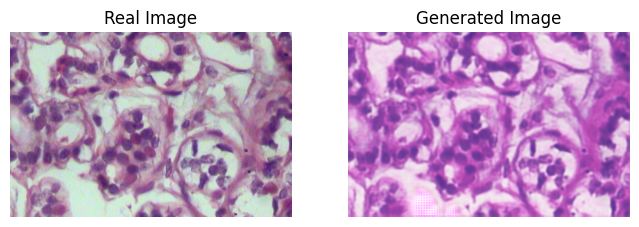

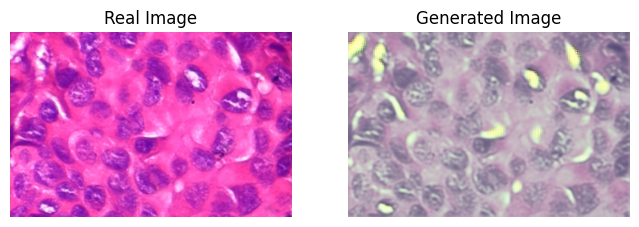

In [ ]:
for i in range(3):
    print("Image : ", i)
    plot_single_real_and_fake_image(real_A[0], fake_B[0])  # Pass the first image of the batch
    plot_single_real_and_fake_image(real_B[0], fake_A[0])

# **🌀 Evaluation: Simple CycleGAN**

This section focuses on evaluating the baseline **Simple CycleGAN** model. This model uses a standard generator-discriminator architecture without any pretrained components. The evaluation will help us understand the foundational performance of the vanilla CycleGAN in translating between benign and malignant medical images.


## 🧰 Transformations for Test Data

We define image preprocessing steps including resizing, center cropping, normalization, and tensor conversion — all of which are consistent with the preprocessing used during model training.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## ⚙️ Hyperparameters Setup

We define key hyperparameters:
- `input_nc` and `output_nc`: number of channels (3 for RGB).
- `n_residual_blocks`: number of ResNet blocks in the generator.
- `lr` and `beta1`: learning rate and optimizer momentum for consistency.


In [ ]:
input_nc = 3  # number of channels in the input images
output_nc = 3  # number of channels in the output images
n_residual_blocks = 9  # typical number for a CycleGAN

lr = 0.0002
beta1 = 0.5

## 🧠 Generator Definition

We implement the CycleGAN generator with:
- An initial convolutional block.
- Two downsampling layers.
- Nine residual blocks for deep feature learning.
- Two upsampling layers.
- A final convolutional output layer using Tanh activation.


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


## 🛡️ Discriminator Definition

We define a **PatchGAN discriminator**, which:
- Operates on local image patches.
- Consists of convolutional layers with instance normalization and LeakyReLU activations.
- Outputs a 2D map where each value represents real/fake prediction for a local patch.


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True)]

        # Output layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## 💾 Load Trained CycleGAN Models

We load the pretrained generator and discriminator models from Google Drive checkpoints. A utility function is used to load model weights even if some layers slightly mismatch (e.g., due to architectural changes).


In [ ]:
# Paths to the saved models
G_A2B_path = '/content/drive/MyDrive/CycleGAN_Models/netG_A2B_epoch_24.pth'
G_B2A_path = '/content/drive/MyDrive/CycleGAN_Models/netG_B2A_epoch_24.pth'
D_A_path = '/content/drive/MyDrive/CycleGAN_Models/netD_A_epoch_24.pth'
D_B_path = '/content/drive/MyDrive/CycleGAN_Models/netD_B_epoch_24.pth'

# Load the models
G_A2B = Generator(input_nc,output_nc).to(device)
G_B2A = Generator(input_nc,output_nc).to(device)
D_A = Discriminator(input_nc).to(device)
D_B = Discriminator(input_nc).to(device)

def load_model_ignore_mismatch(model, state_dict):
    model_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

# Usage example:
# Load the trained models with map_location for CPU
G_A2B.load_state_dict(torch.load(G_A2B_path, map_location=torch.device('cpu')))
G_B2A.load_state_dict(torch.load(G_B2A_path, map_location=torch.device('cpu')))

state_dict_D_A = torch.load(D_A_path, map_location=torch.device('cpu'))
state_dict_D_B = torch.load(D_B_path, map_location=torch.device('cpu'))

load_model_ignore_mismatch(D_A, state_dict_D_A)
load_model_ignore_mismatch(D_B, state_dict_D_B)

#load_model_ignore_mismatch(D_A_path, map_location=torch.device('cpu')))
#load_model_ignore_mismatch(D_B_path, map_location=torch.device('cpu')))

#D_A.load_state_dict(torch.load(D_A_path, map_location=torch.device('cpu')))
#D_B.load_state_dict(torch.load(D_B_path, map_location=torch.device('cpu')))





## 📁 Prepare Output Directories

We create folders for saving:
- **Generated test images** (`benign_to_malignant`, `malignant_to_benign`).
- **Real test images** for comparison.
This helps in organized result visualization and evaluation.


In [ ]:
import os
from torchvision.utils import save_image
# Directories for saving generated test images
os.makedirs('/content/drive/MyDrive/test_generated_by_real_cyclegan/benign_to_malignant', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_generated_by_real_cyclegan/malignant_to_benign', exist_ok=True)
# Directories for saving real test images
os.makedirs('/content/drive/MyDrive/test_real_by_real_cyclegan/real_benign', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_real_by_real_cyclegan/real_malignant', exist_ok=True)

## 📊 Image Translation and Metric Computation

We evaluate the models using:
- **SSIM (Structural Similarity Index)**
- **PSNR (Peak Signal-to-Noise Ratio)**
- **MSE (Mean Squared Error)**

For each image pair (real vs generated), we:
- Generate fake images in both directions.
- Print tensor shapes to verify dimensions.
- Convert tensors to NumPy arrays.
- Calculate visual similarity metrics.
- Append values for aggregated analysis.

🚫 *Note*: Segmentation-based IoU and per-pixel/class accuracy are commented out in this version. They can be re-enabled for structure-aware evaluation later.


In [ ]:
import os
import torch
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Function to compute MSE
def mse(img1, img2):
    return F.mse_loss(img1, img2).item()

# Lists to store metrics
s_ssim_values = []
s_psnr_values = []
s_mse_values = []

with torch.no_grad():
    for i, (data_A, data_B) in enumerate(zip(test_loader_A, test_loader_B)):
        print(f'Processing image {i+1}')
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        #save_image(fake_B, f'/content/drive/MyDrive/test_generated_by_real_cyclegan/benign_to_malignant/{i}.png')
        #save_image(fake_A, f'/content/drive/MyDrive/test_generated_by_real_cyclegan/malignant_to_benign/{i}.png')
        #save_image(real_A, f'/content/drive/MyDrive/test_real_by_real_cyclegan/real_benign/{i}.png')
        #save_image(real_B, f'/content/drive/MyDrive/test_real_by_real_cyclegan/real_malignant/{i}.png')

        # Check shapes before transposing
        print(f'Shape of real_A: {real_A.shape}')
        print(f'Shape of real_B: {real_B.shape}')
        print(f'Shape of fake_A: {fake_A.shape}')
        print(f'Shape of fake_B: {fake_B.shape}')

        # Remove batch dimension and convert images to numpy arrays
        real_A_np = real_A[0].cpu().numpy().transpose(1, 2, 0)
        real_B_np = real_B[0].cpu().numpy().transpose(1, 2, 0)
        fake_A_np = fake_A[0].cpu().numpy().transpose(1, 2, 0)
        fake_B_np = fake_B[0].cpu().numpy().transpose(1, 2, 0)

        # Compute metrics for benign to malignant
        ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
        psnr_value = psnr(real_B_np, fake_B_np)
        mse_value = mse(real_B, fake_B)

        s_ssim_values.append(ssim_value)
        s_psnr_values.append(psnr_value)
        s_mse_values.append(mse_value)

        # Compute metrics for malignant to benign
        ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)
        psnr_value = psnr(real_A_np, fake_A_np)
        mse_value = mse(real_A, fake_A)

        s_ssim_values.append(ssim_value)
        s_psnr_values.append(psnr_value)
        s_mse_values.append(mse_value)

        # Get segmentation maps
        #seg_map_real_B = get_segmentation_map(real_B, fcn_model)
        #seg_map_fake_B = get_segmentation_map(fake_B, fcn_model)
        #seg_map_real_A = get_segmentation_map(real_A, fcn_model)
        #seg_map_fake_A = get_segmentation_map(fake_A, fcn_model)

        # Calculate IoU
        #iou_B = calculate_iou(seg_map_real_B, seg_map_fake_B)
        #iou_A = calculate_iou(seg_map_real_A, seg_map_fake_A)

        #iou_scores.append((iou_A + iou_B) / 2)  # Average IoU for both directions

         # Calculate metrics for benign to malignant
        #ppa_B = calculate_per_pixel_accuracy(seg_map_real_B, seg_map_fake_B)
        #pca_B = calculate_per_class_accuracy(seg_map_real_B, seg_map_fake_B)

        # Calculate metrics for malignant to benign
       # ppa_A = calculate_per_pixel_accuracy(seg_map_real_A, seg_map_fake_A)
        #pca_A = calculate_per_class_accuracy(seg_map_real_A, seg_map_fake_A)

        # Average metrics for both directions
       # ppa_scores.append((ppa_A + ppa_B) / 2)
        #pca_scores.append((pca_A + pca_B) / 2)

Processing image 1
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 2


<ipython-input-18-bfb00698ef54>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-bfb00698ef54>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 3
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 4
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 5
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 6
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Proc

# **🔬 Evaluation: TL-S-CycleGAN (VGG-16 Discriminator)**

In this section, we assess the performance of the **TL-S-CycleGAN model with a VGG-16-based discriminator**. Leveraging the classic VGG-16 architecture, this model is expected to focus on texture and fine-grained details in image translation. The evaluation here highlights how VGG-based feature learning influences the CycleGAN’s ability to generate medically relevant image translations.


## 🧰 Data Transformation

We use a `transforms.Compose` pipeline to prepare input images:
- Convert to tensor.
- Resize to 224×224 (VGG input size).
- Normalize using mean and std of 0.5 for each RGB channel.

In [ ]:
# Load Data
#Sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 🧠 Generator Definition (ResNet-Based)

The generator architecture uses:
- **Initial Convolution Block** with Reflection Padding.
- **Two Downsampling Layers** to reduce spatial resolution.
- **Nine ResNet Blocks** to model image translation features.
- **Two Upsampling Layers** to restore spatial dimensions.
- **Final Convolution + Tanh Activation** to output RGB images in [-1, 1].

Each `ResnetBlock` uses:
- 2 convolution layers.
- Optional dropout.
- Residual (shortcut) connection.

In [ ]:
#######Generator##########
#########################

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=9, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf #no of generator filters
        #n_blocks = resnet blocks

        #Initial convlutional block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        # Downsample
        #reducing spatial dimensions
        n_downsampling = 2 #no. of downsampling layers
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        # Resnet blocks
        #using shortcut connections bypassing few layers
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type='reflect', norm_layer=norm_layer, use_dropout=use_dropout, use_bias=True)]

        # Upsample
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)
#resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        # Create the convolutional block
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)
    #function to build convolution block
    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = [] #to hold layers
        p = 0

        #determining padding type for first layer
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        else:
            p = 1  # 'zero' padding
        #first convolution layer
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        #opyional dropout layer
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        #determining padding type for 2nd layer
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        else:
            p = 1  # 'zero' padding
        #second convolutional block
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

## 🛡️ VGG-16 Based Discriminator

The discriminator (`CustomDiscriminator`) is designed to:
- Use **VGG-16 pretrained features** to extract high-level image representations.
- Perform **binary classification** for Fake vs Real images.
- Simultaneously classify images as **Benign vs Malignant**.

Structure:
- Uses `vgg16.features` for spatial encoding.
- Flattens the feature map (size: 512 × 7 × 7).
- Two fully connected branches:
  - One for **Fake/Real** (with sigmoid output).
  - One for **Benign/Malignant** (multi-class logits).

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomDiscriminator(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDiscriminator, self).__init__()
        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Remove the classifier part of VGG16
        self.features = vgg16.features

        # Calculate the size of the feature map after VGG16 features
        # Assuming input image size of (3, 224, 224)
        self.feature_map_size = 512 * 7 * 7

        # Define the classifier for fake/real
        self.fake_real_classifier = nn.Sequential(
            nn.Linear(self.feature_map_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1),  # Binary classification (fake/real)
            nn.Sigmoid()
        )

        # Define the classifier for benign/malignant
        self.benign_malignant_classifier = nn.Sequential(
            nn.Linear(self.feature_map_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  # Multi-class classification (benign/malignant)
        )

    def forward(self, x):
        # Extract features using VGG16
        features = self.features(x)
        features = features.view(features.size(0), -1)  # Flatten the feature map

        # Fake/Real classification
        fake_real_output = self.fake_real_classifier(features)

        # Benign/Malignant classification
        benign_malignant_output = self.benign_malignant_classifier(features)

        return fake_real_output, benign_malignant_output


## 💾 Load Pretrained Models

We load saved weights from disk:
- `G_A2B` and `G_B2A` (Generators).
- `D_A` and `D_B` (Discriminators using VGG-16).

A helper function `load_model_ignore_mismatch()` ensures compatibility even if minor architectural differences exist between saved and current models.

In [ ]:
# Paths to the saved models
G_A2B_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netG_A2B_epoch_24.pth'
G_B2A_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netG_B2A_epoch_24.pth'
D_A_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netD_A_epoch_24.pth'
D_B_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netD_B_epoch_24.pth'

# Load the models
G_A2B = ResnetGenerator(input_nc,output_nc).to(device)
G_B2A = ResnetGenerator(input_nc,output_nc).to(device)
D_A = CustomDiscriminator(input_nc).to(device)
D_B = CustomDiscriminator(input_nc).to(device)

def load_model_ignore_mismatch(model, state_dict):
    model_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

# Usage example:
# Load the trained models with map_location for CPU
G_A2B.load_state_dict(torch.load(G_A2B_path, map_location=torch.device('cpu')))
G_B2A.load_state_dict(torch.load(G_B2A_path, map_location=torch.device('cpu')))

state_dict_D_A = torch.load(D_A_path, map_location=torch.device('cpu'))
state_dict_D_B = torch.load(D_B_path, map_location=torch.device('cpu'))

load_model_ignore_mismatch(D_A, state_dict_D_A)
load_model_ignore_mismatch(D_B, state_dict_D_B)

#load_model_ignore_mismatch(D_A_path, map_location=torch.device('cpu')))
#load_model_ignore_mismatch(D_B_path, map_location=torch.device('cpu')))

#D_A.load_state_dict(torch.load(D_A_path, map_location=torch.device('cpu')))
#D_B.load_state_dict(torch.load(D_B_path, map_location=torch.device('cpu')))





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:12<00:00, 43.2MB/s]


## 📁 Output Directories

Create directories to store:
- Translated/generated test images (`benign_to_malignant` and `malignant_to_benign`).
- Ground-truth real test images (`real_benign` and `real_malignant`).

This helps facilitate organized evaluation and comparison.

In [ ]:
import os
from torchvision.utils import save_image
# Directories for saving generated test images
os.makedirs('/content/drive/MyDrive/test_generated_by_real_cyclegan/benign_to_malignant', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_generated_by_real_cyclegan/malignant_to_benign', exist_ok=True)
# Directories for saving real test images
os.makedirs('/content/drive/MyDrive/test_real_by_real_cyclegan/real_benign', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_real_by_real_cyclegan/real_malignant', exist_ok=True)

## 📊 Evaluation Loop: Metric Computation

We evaluate generated images using the following metrics:

- **SSIM**: Structural Similarity Index.
- **PSNR**: Peak Signal-to-Noise Ratio.
- **MSE**: Mean Squared Error.

For each test image pair:
- Convert model outputs and real images to NumPy arrays.
- Calculate visual quality metrics for:
  - Benign → Malignant.
  - Malignant → Benign.
- Print tensor shapes to ensure correct dimensions.

Optional (commented out for now):
- Use segmentation models (e.g., FCN) to compute:
  - IoU (Intersection over Union).
  - Per-Pixel Accuracy (PPA).
  - Per-Class Accuracy (PCA).

In [ ]:
import os
import torch
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Function to compute MSE
def mse(img1, img2):
    return F.mse_loss(img1, img2).item()

# Lists to store metrics
v_ssim_values = []
v_psnr_values = []
v_mse_values = []

with torch.no_grad():
    for i, (data_A, data_B) in enumerate(zip(test_loader_A, test_loader_B)):
        print(f'Processing image {i+1}')
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        #save_image(fake_B, f'/content/drive/MyDrive/test_generated_by_real_cyclegan/benign_to_malignant/{i}.png')
        #save_image(fake_A, f'/content/drive/MyDrive/test_generated_by_real_cyclegan/malignant_to_benign/{i}.png')
        #save_image(real_A, f'/content/drive/MyDrive/test_real_by_real_cyclegan/real_benign/{i}.png')
       # save_image(real_B, f'/content/drive/MyDrive/test_real_by_real_cyclegan/real_malignant/{i}.png')

        # Check shapes before transposing
        print(f'Shape of real_A: {real_A.shape}')
        print(f'Shape of real_B: {real_B.shape}')
        print(f'Shape of fake_A: {fake_A.shape}')
        print(f'Shape of fake_B: {fake_B.shape}')

        # Remove batch dimension and convert images to numpy arrays
        real_A_np = real_A[0].cpu().numpy().transpose(1, 2, 0)
        real_B_np = real_B[0].cpu().numpy().transpose(1, 2, 0)
        fake_A_np = fake_A[0].cpu().numpy().transpose(1, 2, 0)
        fake_B_np = fake_B[0].cpu().numpy().transpose(1, 2, 0)

        # Compute metrics for benign to malignant
        ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
        psnr_value = psnr(real_B_np, fake_B_np)
        mse_value = mse(real_B, fake_B)

        v_ssim_values.append(ssim_value)
        v_psnr_values.append(psnr_value)
        v_mse_values.append(mse_value)

        # Compute metrics for malignant to benign
        ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)
        psnr_value = psnr(real_A_np, fake_A_np)
        mse_value = mse(real_A, fake_A)

        v_ssim_values.append(ssim_value)
        v_psnr_values.append(psnr_value)
        v_mse_values.append(mse_value)

        # Get segmentation maps
       # seg_map_real_B = get_segmentation_map(real_B, fcn_model)
       # seg_map_fake_B = get_segmentation_map(fake_B, fcn_model)
       # seg_map_real_A = get_segmentation_map(real_A, fcn_model)
       # seg_map_fake_A = get_segmentation_map(fake_A, fcn_model)

        # Calculate IoU
       # iou_B = calculate_iou(seg_map_real_B, seg_map_fake_B)
        #iou_A = calculate_iou(seg_map_real_A, seg_map_fake_A)

        #iou_scores.append((iou_A + iou_B) / 2)  # Average IoU for both directions

         # Calculate metrics for benign to malignant
        #ppa_B = calculate_per_pixel_accuracy(seg_map_real_B, seg_map_fake_B)
        #pca_B = calculate_per_class_accuracy(seg_map_real_B, seg_map_fake_B)

        # Calculate metrics for malignant to benign
        #ppa_A = calculate_per_pixel_accuracy(seg_map_real_A, seg_map_fake_A)
        #pca_A = calculate_per_class_accuracy(seg_map_real_A, seg_map_fake_A)

        # Average metrics for both directions
        #ppa_scores.append((ppa_A + ppa_B) / 2)
       # pca_scores.append((pca_A + pca_B) / 2)

Processing image 1
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-24-57a081949b09>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-24-57a081949b09>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 2
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 3
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 4
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 5
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])
Processing image 6
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1,

## 📊 Metric Comparison: SSIM, PSNR, and MSE for All Models

In this section, we visualize the **image quality metrics** across the three CycleGAN variants:

- **SSIM (Structural Similarity Index)**: Measures perceived quality by comparing luminance, contrast, and structure between generated and ground truth images.
- **PSNR (Peak Signal-to-Noise Ratio)**: Assesses reconstruction quality — higher values indicate better fidelity.
- **MSE (Mean Squared Error)**: Calculates the average squared differences between generated and real pixels — lower values are better.

These plots help us compare the translation effectiveness of:
- **Simple CycleGAN**
- **TL-S-CycleGAN with ResNet-50**
- **TL-S-CycleGAN with VGG-16**

By examining these metrics across sample indices, we gain insight into which architecture yields the most perceptually and quantitatively accurate results.


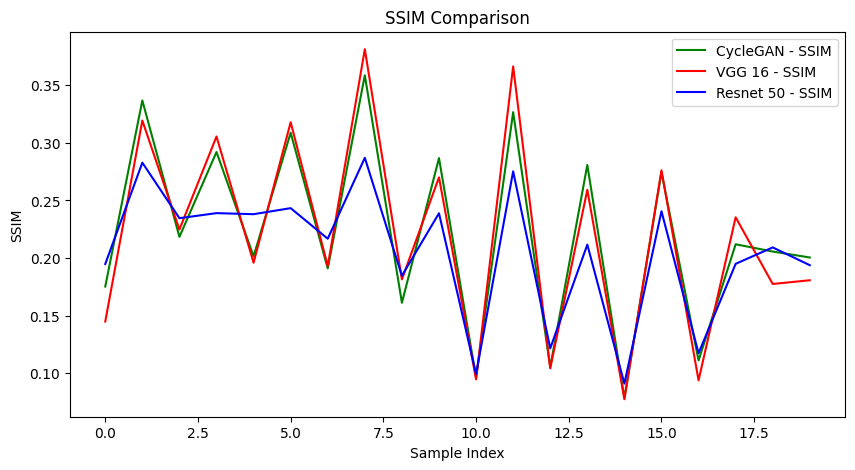

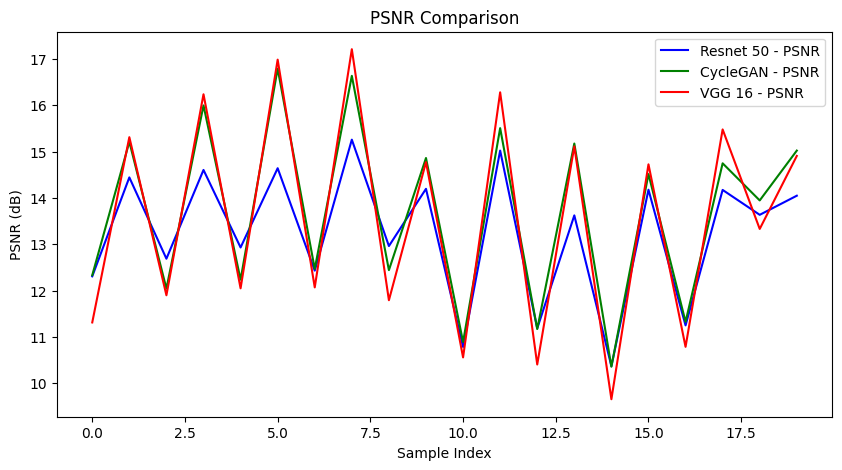

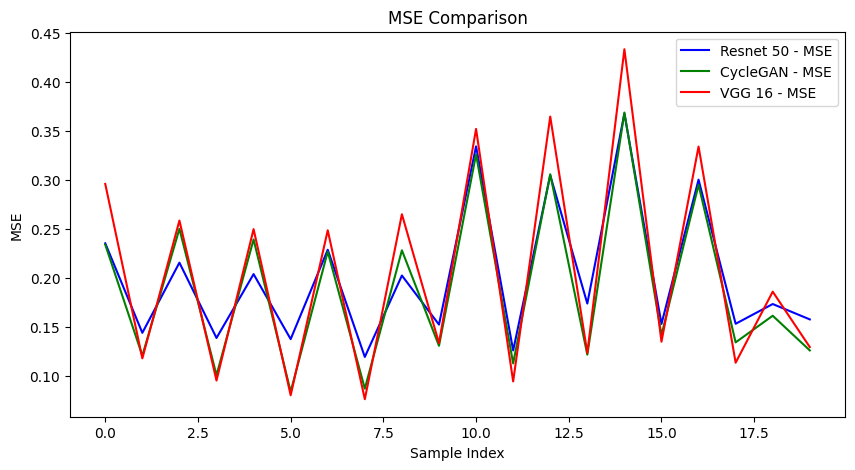

In [ ]:
# Plot SSIM values
plt.figure(figsize=(10, 5))

plt.plot(s_ssim_values, label='CycleGAN - SSIM', color='green')
plt.plot(v_ssim_values, label='VGG 16 - SSIM', color='red')
plt.plot(r_50_ssim_values, label='Resnet 50 - SSIM', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('SSIM')
plt.title('SSIM Comparison')
plt.legend()
plt.show()

# Plot PSNR values
plt.figure(figsize=(10, 5))
plt.plot(r_50_psnr_values, label='Resnet 50 - PSNR', color='blue')
plt.plot(s_psnr_values, label='CycleGAN - PSNR', color='green')
plt.plot(v_psnr_values, label='VGG 16 - PSNR', color='red')
plt.xlabel('Sample Index')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Comparison')
plt.legend()
plt.show()

# Plot MSE values
plt.figure(figsize=(10, 5))
plt.plot(r_50_mse_values, label='Resnet 50 - MSE', color='blue')
plt.plot(s_mse_values, label='CycleGAN - MSE', color='green')
plt.plot(v_mse_values, label='VGG 16 - MSE', color='red')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('MSE Comparison')
plt.legend()
plt.show()